## Objective
    - implement version space for SVM and Boosting algorithms
    - verify how its volume changes after each iteration of the AL algorithm
    - check for possible optimizations

In [1]:
# set code path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## SVM Version Space - Tong and Koller

When defining the Version Space for SVM-based Acrive Learning, Tong and Koller make some hypothesis on the data distribution:

   - Linearly separable in the feature space by a CENTERED hyperplane (no intercept / bias)
   - All points have constant norm over the features space (e.g. Gaussian Kernel)
    
Under these hypothesis, the Version Space is defined as: 

$$
V = \{w \in \mathcal{F}, \Vert w \Vert_{\mathcal{F}} = 1 \text{ and } y_i \langle w, \phi(x_i) \rangle \geq 0\}
$$

where $\mathcal{F}$ is the feature space and $\{(x_i, y_i)\}_{i=1}^n$ is the training set.

## 2-dimensional version space
   - Let's consider the simple case of $\textbf{linear kernel}$ for $\textbf{2-dimensional}$ input
   - Version Space = circle in $\mathbb{R}^2$
   - Easy to visualize and compute the Version Space reduction per iteration

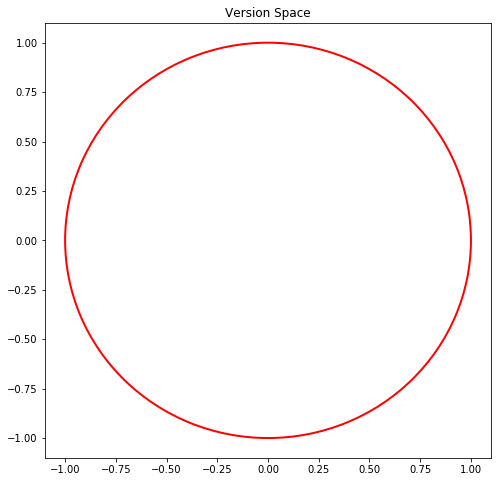

Point:  (1.000, 0.000)


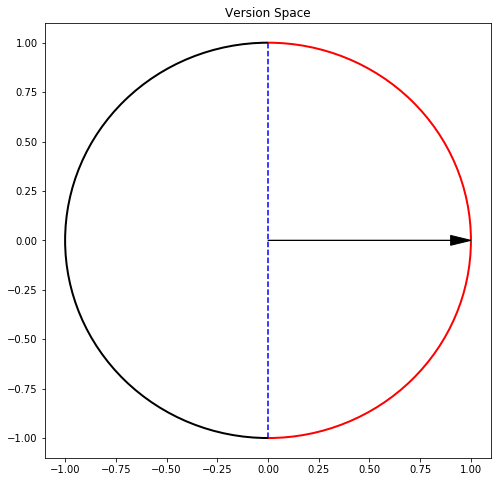

Point:  (1.000, 1.000)


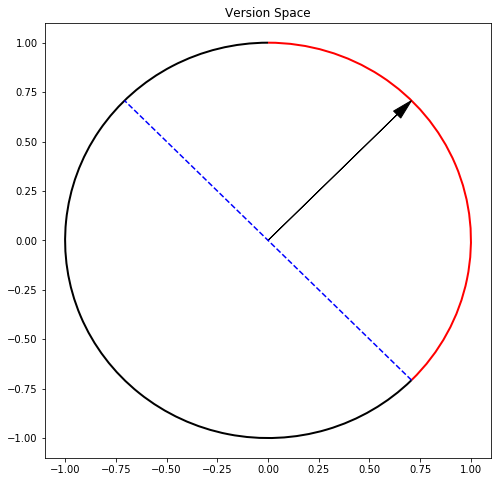

Point:  (1.000, -1.000)


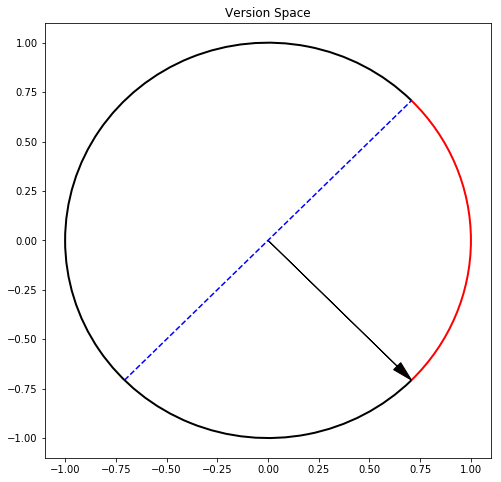

Point:  (0.000, 1.000)


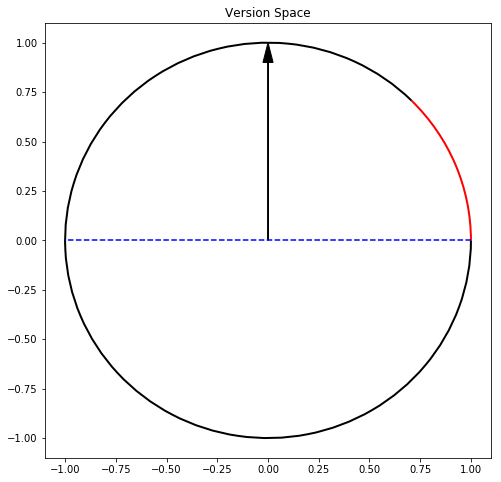

In [3]:
from src.version_space.two_dimensional import Point, Circle
from matplotlib.patches import Arc
import math

def plot_arc(ax, theta1=0, theta2=360, color='k', linewidth=2.0):
    arc_patch = Arc(xy=[0,0], width=2.0, height=2.0, angle=0.0, 
                    theta1=theta1, theta2=theta2, color=color, linewidth=linewidth)
    ax.add_patch(arc_patch)

def plot_version_space(vs, point=None):
    # start figure
    fig, ax = plt.subplots(figsize=(8,8))

    # set plot configs
    ax.set_title("Version Space")
    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))
    
    # if full version space, only draw circle
    if vs.volume == 2*math.pi:
        plot_arc(ax, color='r')
        return ax
    
    # get angle of VS delimiters
    th0 = vs.left_limit.angle.deg
    th1 = vs.right_limit.angle.deg
    
    # plot arcs
    plot_arc(ax, theta1=th0, theta2=th1, color='r', linewidth=2.0)
    plot_arc(ax, theta1=th1, theta2=th0, color='k', linewidth=2.0)
    
    # plot point
    norm = point.normalize()
    ax.arrow(0, 0, 0.9*norm.x, 0.9*norm.y, head_width=0.05, head_length=0.1, fc='k', ec='k')
    
    # plot perpendicular line
    cut1 = norm.orthogonal()
    cut0 = -cut1
    ax.plot([cut0.x, cut1.x], [cut0.y, cut1.y], color='b', linestyle='dashed')
    
    return ax
    
vs = Circle()
ax = plot_version_space(vs)
plt.show()

points_list = [
    Point(1,0),
    Point(1,1),
    Point(1,-1),
    Point(0,1),
]
# plot cuts
for point in points_list:
    vs.cut(point)
    ax = plot_version_space(vs, point)
    print("Point: ", point)
    plt.show()

In [4]:
vs.angle_limits()

(0.0, 0.7853981633974483)

## Import dataset: Housing
    - Size: 645 points, 2 dimensions
    - Preprocessing: each column is standardized
    - Positive samples query: x[0] + x[1] <= 0
    - Percentage of positive samples: 3.9 %

In [5]:
# import housing dataset
from sklearn.preprocessing import StandardScaler
from src.user import DummyUser

scaler = StandardScaler()

data = pd.read_csv("../data/housing/housing.data", header=None)
data = data[[2, 7, 8, 9, 10, 11, 12, 4, 5]]
max_iter = 50

X_housing = data.values
X_housing_fit = scaler.fit_transform(X_housing) + 1
y_housing = 2*(np.sum(X_housing_fit[:,:2], axis=1) <= 0) - 1
print("Percentage of positive samples: %.2f " % (100.0*(y_housing == 1).sum()/len(y_housing)))
print("Number of positive samples: ", (y_housing == 1).sum())

datasets_list = []
max_iter = 50

for col_list in [[0,1], [0,1,2,3], [0,1,2,3,4,5], [0,1,2,3,4,5,6,7]]:
    user_housing = DummyUser(max_iter=max_iter, y_true=y_housing)
    datasets_list.append(('housing_'+str(len(col_list)), X_housing_fit[:, col_list], user_housing))

Percentage of positive samples: 3.88 
Number of positive samples:  25


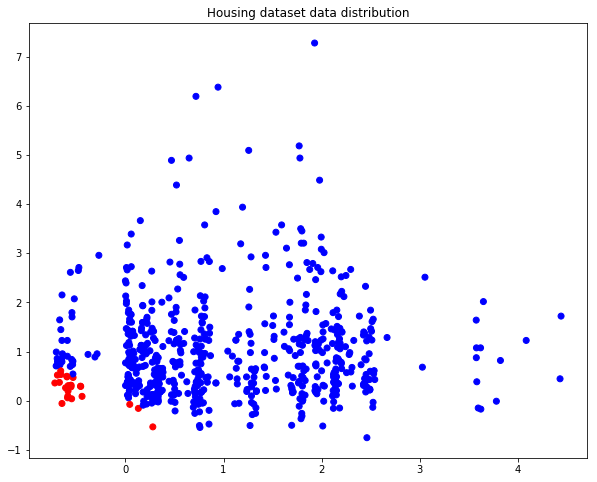

In [6]:
plt.figure(figsize=(10,8))
plt.title("Housing dataset data distribution")
plt.scatter(X_housing_fit[:,0], X_housing_fit[:,1], c=list(map(lambda x: 'r' if x == 1 else 'b', y_housing)))
plt.show()

In [7]:
# testing that data is linearly separable
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

clf = LinearSVC(C=200, fit_intercept=False)
clf.fit(X_housing_fit, y_housing)
print("Final F-score of Linear SVM model: ", f1_score(y_pred=clf.predict(X_housing_fit), y_true=y_housing))

Final F-score of Linear SVM model:  1.0


## Observing Version Space reduction
    - Algorithm: Simple Margin with linear kernel (Tong and Koller)
    - We also compared with two other AL: Random and Solver Method
    - Initial sampling: one positive and one negative points are randomly sampled
    - 100 samples are labeled at every run
    - Results are averaged over 100 runs
    - We compute the f-score over the entire database at every iteration, and version space reduction

total time 88.96763896942139


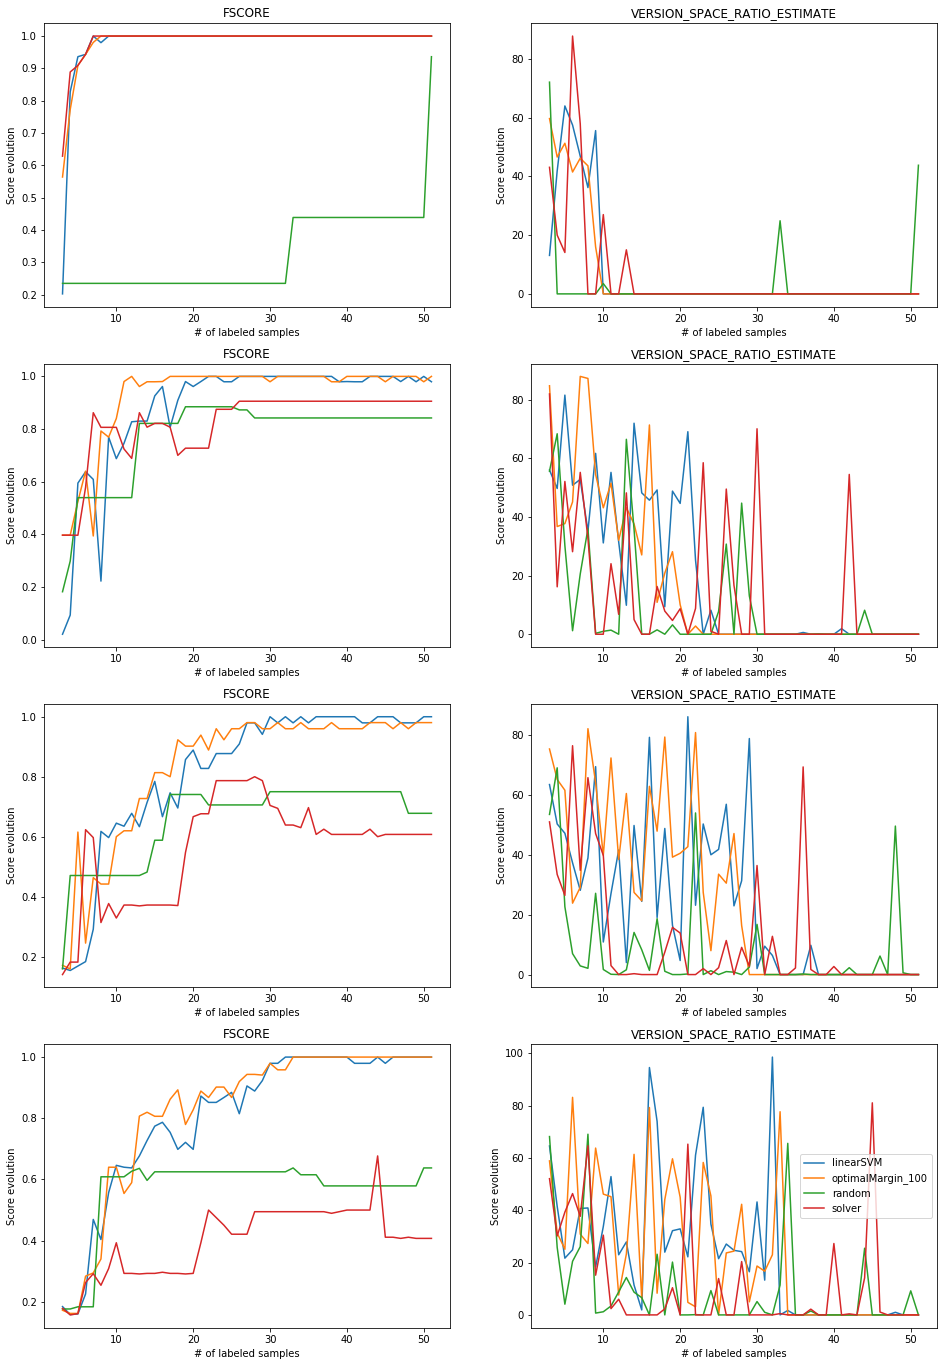

In [10]:
from src.initial_sampling import FixedSizeStratifiedSampler
from src.showdown import Showdown
from src.plotting import plot_showdown

from src.active_learning.svm import SimpleMargin, SolverMethod, OptimalMargin
from src.active_learning.agnostic import RandomLearner
from src.version_space.two_dimensional import Circle
from src.version_space.svm import SVMVersionSpace
# AL list

active_learners_list = [
     ("random", RandomLearner(LinearSVC(C=200, fit_intercept=False))),
     ("linearSVM", SimpleMargin(kind='linear', C=200, fit_intercept=False)),
     ("solver", SolverMethod(kind='linear', pool_size=50, C=200, kernel='linear', fit_intercept=False)),
     #("optimalMargin_10", OptimalMargin(C=200, fit_intercept=False, chain_length=10)),
     ("optimalMargin_100", OptimalMargin(C=200, fit_intercept=False, chain_length=100)),
     #("optimalMargin_500", OptimalMargin(C=200, fit_intercept=False, chain_length=500)),
     #("optimalMargin_1000", OptimalMargin(C=200, fit_intercept=False, chain_length=1000))
]

# datasets
#datasets_list = [
#    ("housing", X_housing_fit, user_housing)
#]

# set showdown and run
times = 1
initial_sampler = FixedSizeStratifiedSampler(sample_size=2)
showdown = Showdown(times, initial_sampler)
from time import time
t0 = time()
output = showdown.run(datasets_list, active_learners_list)
print("total time", time() - t0)
# plot results
#print(output.head())
plot_showdown(output, times, metrics_list=['fscore', 'version_space_ratio_estimate'])

## Where to go from here
  - $\textbf{Observation on above results}$: the linear kernel example was viable for two reasons:
      - Simple feature function: $\phi(x) = x$
      - Low-dimensionality of feature space (dim = 2)
      
  - $\textbf{Extension to general kernel}$ 
      - Inspired on Enhui's paper, we could perform a Cholesky decomposition of the kernel matrix ($K = L^t L \Rightarrow \phi(x_i) = l_i$)
      - However, we are left with computing the area of intersection of several hyperplanes with an unit sphere in $\mathbb{R}^n$, which is non-trivial for $n > 2$.
      
     
  - Similar sitiation happens with Actboost: version space is a high-dimensional polytope (dimension = # of weak-learners), and computing volumes of high-dimensional objects is difficult.

## Computing volumes

   - By observing the literature, we can understand a few things about volume estimation:
       - Deterministic volume estimation of convex bodies is NP-hard (I. Bárány & Z. Füredi, Computing the volume is difficult, Discrete and Computational Geometry, 1987)
       - There are polynomial-time randomized algorithms for volume approximation
       - Still, today's algorithms cannot handle high-dimensional volume estimation very well (> 100)

## Future steps

  - Try to implement the most promissing volume compution routines and check whether results seem consistent
  - Perform some kind of feature selection / dimensionality reduction before volume computation?
  - Is there any relation between version space volume and f-score?

## Notes

  - Linear kernel: 4d, 6d -> 2d linear subspace search
  - Volume computation algorithm
  - Factorization: leverage factorized user predictate (F(x1) and F(x2))?

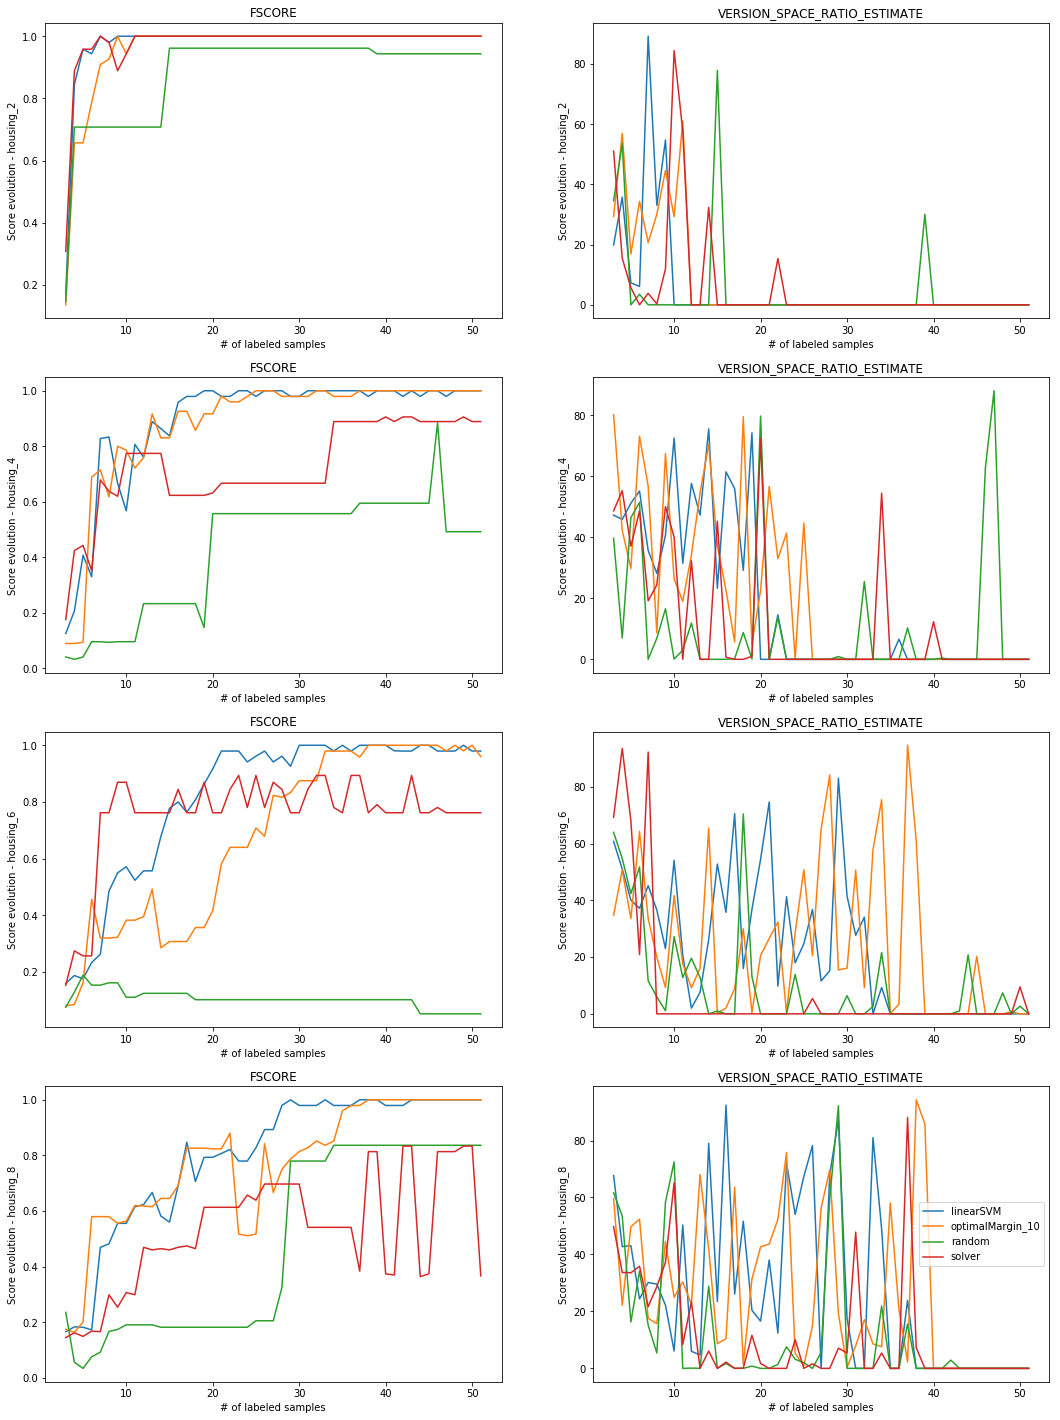

In [9]:
from math import sqrt
def plot_showdown(output, times, metrics_list=None):
    data_tags = output.columns.levels[0]

    if metrics_list is None:
        metrics_list = output.columns.levels[1]
    als = output.columns.levels[2]

    fig, axs = plt.subplots(len(data_tags), len(metrics_list))
    if len(data_tags) == 1:
        axs = [axs]

    fig.set_size_inches(18, 25)

    for i, ds in enumerate(data_tags):
        for j, name in enumerate(metrics_list):
            ax = axs[i][j]
            ax.set_title(name.upper())
            ax.set_xlabel("# of labeled samples")
            ax.set_ylabel("Score evolution - " + ds)

            for al in als:
                df = output[ds][name][al]
                x = df.index
                y = df['mean']
                error = 1.96 * df['std'] / sqrt(times)
                ax.plot(x, y, label=al)

                ax.fill_between(x, y - error, y + error, alpha=0.1)

    plt.legend()
    plt.savefig('/Users/luciano/Downloads/plot2.png')
    plt.show()


plot_showdown(output, times, metrics_list=['fscore', 'version_space_ratio_estimate'])

## Factoring predicates

  - True query: SELECT x1, x2 FROM table WHERE P(x1) AND P(x2)  -> predicate factored over x1 and x2 
  - Active learning scenario: we keep track of two classifiers, one over $x_1$ ($h_1(x_1)$) and another over $x_2$ ($h_2(x_2)$)
  
  - Picking the next point:
      - train SVM over all points and use Simple Margin/Solver/...
      - disagreement coefficient; or where $P(Y=1|X_1 = x_1)$ and $P(Y=1|X_2 = x_2)$ disagree the most. Use a classifier that estimates these quantities (RVM, SVM + Platt scaling, Random Forest, ...)
      
  - Version Space
      - classifiers space can be factored as $\mathcal{H}_1 \times \mathcal{H}_2$, where $\mathcal{H}_i$ is the set of classifiers being trained over $x_i$
      - When the classifiers chosen are SVM or Actboost, then we can associate each $\mathcal{H}_i$ to a version space $V_i$
      - we could track the volume reduction / cutting for each $V_i$ separately
      - Maybe track the "joint volume" 

## Some ideas

 - Computing ratios: let $V_t$ be the version space at iteration $t$. If we only want to compute the ratio $vol(V_{t+1})/vol(V_t)$, we could SAMPLE over $V_t$ (by using Hit-and-Run) and check which proportion of points fall into $V_{t+1}$. This way, we wouldn't need to perform an expensive volume computation.
 - For SVM, where the version space is a sphere, we could sample from the sphere's interior (use the constrain $\Vert \phi(x)\Vert \leq 1$ rather than $\Vert \phi(x)\Vert = 1$) by using Hit-and-Run, and finally project the samples over the sphere (by simply normalizing the samples).

  - solver method cuts the version space
  - general algorithn design: SVM and Actboost -> connection between algorithms and version space
  - solver method version of actboost?
  - validate solver method with Enhui
  
  - use sample at V_t to choose next cut point -> theoretical upper bound
  - sublinear algorithms that approximates this one
  
  - orthogonal initial selection of points (most orthogonal points)
  - extension to actboost?